In [ ]:
# make sure the notebook reloads the module each time we modify it
%load_ext autoreload
%autoreload 2

# Uncomment the next line if you want to be able to zoom on plots
# %matplotlib notebook 

In [ ]:
import parametric_regression_student_version as pr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
import numpy as np
import pymc3 as pm

## Preparing data and utilities

I've prepared a function to generate regression data
$$
y \sim \mathcal{N}(X\theta_{\text{true}}, \sigma^2 I). 
$$
Check how $\theta_{\text{true}}$ is generated, with a few ``support variables", and the rest of the coordinates close to zero.

In [ ]:
dimension = 100
sample_size = 50
X, y, theta_true, sigma_noise, indices_support = pr.generate_data(sample_size = sample_size, 
                                                        dimension = dimension, seed = 3)
plt.plot(X[:,indices_support[0]], y, '+')
plt.plot(X[:,0], y, 'o')
plt.show()

I've prepared a function to plot an estimator and the corresponding error bars, and compare it to the underlying true $\theta_{\text{true}}$ in green. The bottom plot is the same, but with $\theta_{\text{true}}$ substracted.

In [ ]:
fake_std = .5*np.ones(theta_true.shape)
fake_theta_hat = np.zeros(theta_true.shape)
fig, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, color="blue", theta_true=theta_true, indices_support=indices_support, 
                     theta_hat=fake_theta_hat, lower_bound=fake_theta_hat-fake_std, 
                     upper_bound=fake_theta_hat+fake_std)
plt.show()

## Using sklearn's lasso implementation as baseline

Your first exercise is to get scikit-learn's lasso estimate as a baseline. Go to the companion Python file, and fill in the corresponding function. Then plot your estimate and comment.

In [5]:
theta_lasso = pr.get_sklearn_lasso_estimate(X, y)

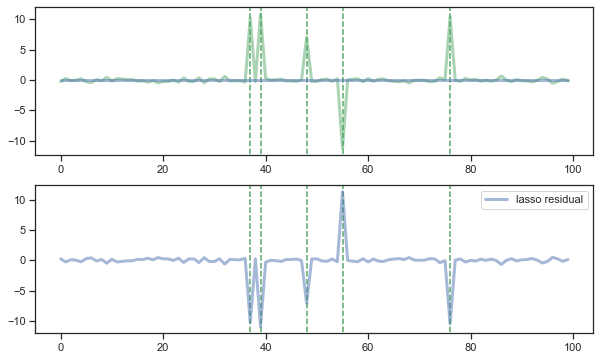

In [6]:
fig, ax = plt.subplots(2, figsize=(10,6))
pr.plot_coefficients(ax, theta_true=theta_true, indices_support=indices_support, theta_hat=theta_lasso, label="lasso")
plt.show()

## Bayesian lasso using a Laplace prior

You second exercise is to use `pymc3` to implement Bayesian linear regression with a Laplace prior. Again, fill in the corresponding function in the companion Python file. You should output a `pymc3` Trace object, with the $\theta$ variable of our regression problem named `theta`. Play around with different MCMC kernels.

*Hint*: Remember, the Laplace prior is the one that makes the MAP estimator be the solution to the frequentist Lasso.

In [7]:
trace = pr.get_mcmc_sample_for_laplace_prior(X, y)
accept = np.sum(trace['theta'][1:,0] != trace['theta'][:-1,0])
print("Acceptance Rate: ", accept/trace['theta'][:,0].shape[0])

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:07<00:00, 11666.46draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Acceptance Rate:  0.3511875


In [8]:
# Let's check a summary of that trace, find out what the columns mean in the doc
pm.summary(trace)

/Users/rbardenet/opt/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta__0,-0.006230,2.126183,0.212263,-1.747358,3.964453,2.066791,6.227684
theta__1,-0.813150,1.443391,0.143562,-2.686173,0.927103,2.470628,2.549823
theta__2,1.898045,1.477779,0.147343,-0.179597,4.029772,2.349777,2.979255
theta__3,-3.069858,2.381324,0.237421,-6.480758,0.428629,2.153754,4.227544
theta__4,-0.131052,2.046329,0.203985,-2.675573,3.406284,2.379731,2.981779
...,...,...,...,...,...,...,...
theta__95,0.881812,0.880346,0.084937,-0.557966,2.321015,2.832363,1.986942
theta__96,0.594614,2.168006,0.216073,-1.593136,5.491986,2.821666,2.152543
theta__97,0.136865,0.525705,0.051675,-1.078377,0.746007,2.982308,1.973108
theta__98,1.989645,2.080639,0.206870,-0.250111,5.765944,2.118968,4.874599


In [ ]:
# Plot here a few trajectories of the chain corresponding to a variable in and out of support. 
plt.show()

Your next exercise is to define the Bayesian estimator $\hat\theta_B$ for the squared loss, along with two vectors of length $d$ as well. They should contain the lower limit and the upper limit, respectively, of a 95% credible interval for each component of $\theta$. I've filled the arrays with zeros for now.

In [14]:
theta_laplace = np.zeros((dimension,))
lower_bound_laplace = np.zeros((dimension,))
upper_bound_laplace = np.zeros((dimension,))

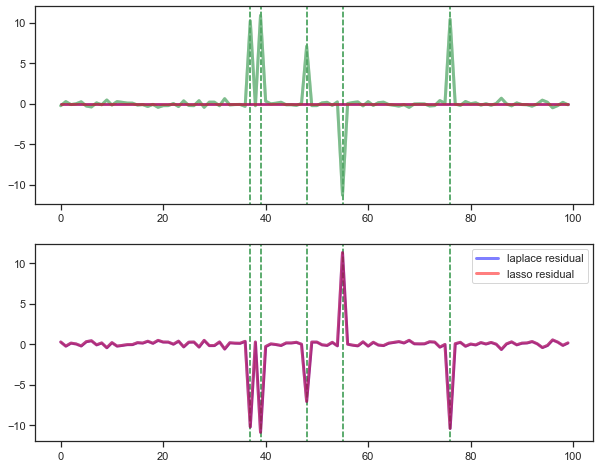

In [15]:
f, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_laplace, lower_bound=lower_bound_laplace, upper_bound=upper_bound_laplace,
             color="blue", label="laplace")
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_lasso, color="red", label="lasso")
plt.show()

The Laplace prior usually tends to overregularize. Can you get rid of that problem playing with the parameters of the prior?

## Bayesian lasso using the horseshoe prior

We'll try to enforce some sparsity using a different prior, the ``horseshoe prior" of [Carvalho et al. '10](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&ved=2ahUKEwj11da8iZvnAhWJz4UKHZSXCccQFjABegQIBBAB&url=ftp%3A%2F%2Fwebster.stat.duke.edu%2Fpub%2FWorkingPapers%2F08-31.pdf&usg=AOvVaw09RPSqHPGq9kyfLBNsMJE2). Your next exercise is to repeat the steps of the Laplace prior for the horseshoe, and see what we gained/lost.

In [16]:
trace_horseshoe = pr.get_mcmc_sample_for_horseshoe_prior(X, y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, lam, tau]
Sampling 4 chains: 100%|██████████| 6000/6000 [02:09<00:00, 46.25draws/s]
There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 209 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 236 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 216 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number 

In [20]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta__0,-0.006230,2.126183,0.212263,-1.747358,3.964453,2.066791,6.227684
theta__1,-0.813150,1.443391,0.143562,-2.686173,0.927103,2.470628,2.549823
theta__2,1.898045,1.477779,0.147343,-0.179597,4.029772,2.349777,2.979255
theta__3,-3.069858,2.381324,0.237421,-6.480758,0.428629,2.153754,4.227544
theta__4,-0.131052,2.046329,0.203985,-2.675573,3.406284,2.379731,2.981779
...,...,...,...,...,...,...,...
theta__95,0.881812,0.880346,0.084937,-0.557966,2.321015,2.832363,1.986942
theta__96,0.594614,2.168006,0.216073,-1.593136,5.491986,2.821666,2.152543
theta__97,0.136865,0.525705,0.051675,-1.078377,0.746007,2.982308,1.973108
theta__98,1.989645,2.080639,0.206870,-0.250111,5.765944,2.118968,4.874599


In [18]:
# Again, fill in the Bayesian estimator for the squared loss and credible intervals.
theta_horseshoe = np.zeros((dimension,))
lower_bound_horseshoe = np.zeros((dimension,))
upper_bound_horseshoe = np.zeros((dimension,))

No handles with labels found to put in legend.
No handles with labels found to put in legend.


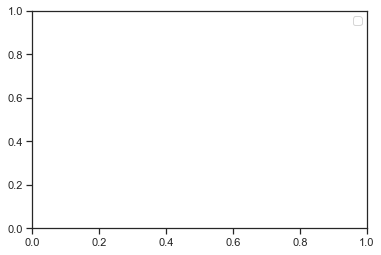

In [19]:
# This will plot your estimates so far for comparison
f, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_laplace, lower_bound=lower_bound_laplace, upper_bound=upper_bound_laplace,
                     color="blue", label="laplace")
pr.plot_coefficients(ax, theta_true=theta_true, indices_support=indices_support, theta_hat=theta_horseshoe, lower_bound=lower_bound_horseshoe, 
                     upper_bound=upper_bound_horseshoe, color="orange", label="horseshoe")
#pr.plot_coefficients(theta_true, theta_lasso, color="red", label="lasso")

plt.show()

## Bayesian lasso using the Finnish horseshoe prior

If you've made it so far, you've deserved to pick your last exercise: either 
* find a dataset of your liking to which you apply the previous estimators. 
* delve into more subtle priors, with, e.g. the Finnish horseshoe prior of [Piironen and Vehtari '17](https://arxiv.org/pdf/1707.01694.pdf). You can use the cells below.
* Try to learn more about HMC and its NUTS variant, the flagship MCMC kernel of `pymc3`. How are the HMC parameters tuned in NUTS? Can you prove that the resulting Markov kernel leaves the target distribution invariant?

In [ ]:
trace_finnish_horseshoe = pr.get_mcmc_sample_for_finnish_horseshoe_prior(X, y)

In [ ]:
theta_finnish_horseshoe = np.zeros((dimension,))
lower_bound_finnish_horseshoe = np.zeros((dimension,))
upper_bound_finnish_horseshoe = np.zeros((dimension,))

In [ ]:
f, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_laplace,
                     color="blue", label="laplace")
pr.plot_coefficients(ax, theta_true=theta_true, indices_support=indices_support, theta_hat=theta_horseshoe, lower_bound=lower_bound_horseshoe, 
                     upper_bound=upper_bound_horseshoe, color="orange", label="horseshoe")
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_finnish_horseshoe, lower_bound=lower_bound_finnish_horseshoe, 
                     upper_bound=upper_bound_finnish_horseshoe, color="magenta", label="finnish")
#pr.plot_coefficients(theta_true, theta_lasso, color="red", label="lasso")

plt.show()